# Text Preprocessing

In [1]:
# 1
import pandas as pd
import yaml
import os
import pathlib

ROOT = pathlib.Path().resolve().parent.parent

with open(ROOT / "config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

DATA_PATH = ROOT / config['api']['DATA_PATH']

In [2]:
# 2

comments = pd.read_excel(DATA_PATH / 'comment' / 'Parent_Comments_UNION.xlsx')

In [3]:
print(comments.shape)

(74963, 20)


In [4]:
# 3
comments = comments.dropna(subset=['snippet.textOriginal'])

In [5]:
# 4

comments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74949 entries, 0 to 74962
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   kind                           74949 non-null  object 
 1   etag                           74949 non-null  object 
 2   id                             74949 non-null  object 
 3   snippet.videoId                74949 non-null  object 
 4   snippet.textDisplay            74949 non-null  object 
 5   snippet.textOriginal           74949 non-null  object 
 6   snippet.authorDisplayName      74939 non-null  object 
 7   snippet.authorProfileImageUrl  74949 non-null  object 
 8   snippet.authorChannelUrl       74943 non-null  object 
 9   snippet.authorChannelId.value  74943 non-null  object 
 10  snippet.canRate                74949 non-null  bool   
 11  snippet.viewerRating           74949 non-null  object 
 12  snippet.likeCount              74949 non-null  int6

# Текст процессинг

In [6]:
# 5

corpora = list(comments['snippet.textOriginal'].values)

In [7]:
# 6

# download stopwords corpus, you need to run it once
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation


#Create lemmatizer and stopwords list
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

", ".join(russian_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, почти, мой, тем, чтобы, нее, сейчас, были, куда, зачем, всех, никогда, можно, при, наконец, два, об, другой, хоть, после, над, больше, тот, через, эти, нас, про, всего, них, какая, много, разве, три, эту, моя, впрочем, хорошо, свою, этой, перед, иногда, лучше, чуть, том, нельзя, такой, им, более, всегда, конечно, всю, между'

In [8]:
# 7 Preprocess functions

import string
import re

PUNCT_TO_REMOVE = string.punctuation

def remove_tabs(text): #убираем дичь со специальными символами
    return text.translate(str.maketrans("\n\t\r", "   "))

def remove_punct(text):
    return re.sub(r'[^a-zA-Zа-яА-ЯёЁ]+',' ', text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text, flags=re.MULTILINE)

def remove_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)

def remove_hashtags(text):
    return re.sub("#[A-Za-z0-9_]+","", text)

def clean_text(text: str)->str:
    text = remove_urls(text)
    text = remove_tabs(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)

    return text


def preprocess_text(text: str) -> str:

    text = remove_punct(text)

    tokens = mystem.lemmatize(text.lower())

    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

In [9]:
# 7 Preprocessing example

test = corpora[14]

print(test)
print()
print('='*10 + 'After' + '='*10)
print()
print(preprocess_text(clean_text(test)))

У нас в стране сейчас оригинал вообще не купить по ходу😂😂😂😂😂

==========After==========

страна оригинал вообще купить ход


In [10]:
# 8 Preprocessing example

cleaned_text = [clean_text(t) for t in corpora]

comments['cleaned_text'] = cleaned_text

In [11]:
# 9 Preprocessing example

lemmatized = [preprocess_text(s) for s in cleaned_text]

comments['lemmatized_text'] = lemmatized

In [12]:
comments

,kind,etag,id,snippet.videoId,snippet.textDisplay,snippet.textOriginal,snippet.authorDisplayName,snippet.authorProfileImageUrl,snippet.authorChannelUrl,snippet.authorChannelId.value,...,snippet.likeCount,snippet.publishedAt,snippet.updatedAt,snippet.canReply,snippet.totalReplyCount,snippet.isPublic,snippet.moderationStatus,snippet.parentId,cleaned_text,lemmatized_text
0,youtube#commentThread,0k0BN3l02ihEAO1Tpx9iNp6S9ZU,UgyKlKuQTfZlkw5sqeN4AaABAg,AAjsSrjZXsw,"Люди тупые, они не понимают, что оригинал стои...","Люди тупые, они не понимают, что оригинал стои...",Елена Марьина,https://yt3.ggpht.com/ytc/AGIKgqM3X8z1SO9ODCNk...,http://www.youtube.com/channel/UCK3lFIDZOZ4rnc...,UCK3lFIDZOZ4rncDMhNB_CbA,...,0,2023-04-21T12:49:12Z,2023-04-21T12:49:12Z,1.0,0.0,1.0,NaN,-1,"Люди тупые, они не понимают, что оригинал стои...",человек тупой понимать оригинал стоять офигенн...
1,youtube#commentThread,yBrfmxWp6CtzE_M6ugZXhSlRhuY,UgwWFRz63uP9kl_Ob-14AaABAg,AAjsSrjZXsw,А где покупать можно качественный оригинальнал?,А где покупать можно качественный оригинальнал?,badrobotturbolovechic,https://yt3.ggpht.com/3u-W9-y7JIuALnpvK02pBz8r...,http://www.youtube.com/channel/UC9-VH4ePIUrD6K...,UC9-VH4ePIUrD6KK8TlAWLDA,...,0,2023-04-20T15:33:12Z,2023-04-20T15:33:12Z,1.0,0.0,1.0,NaN,-1,А где покупать можно качественный оригинальнал?,покупать качественный оригинальнал
2,youtube#commentThread,p9eZKWW9vGjkVEnbGTNXI46m9rA,UgwbiFK59dfmyltqrB94AaABAg,AAjsSrjZXsw,Садовод типо рынка Черкизон?,Садовод типо рынка Черкизон?,Qwertу,https://yt3.ggpht.com/ytc/AGIKgqPCGuXz3r9n6Wwl...,http://www.youtube.com/channel/UCwF8jRd-ZFcOu5...,UCwF8jRd-ZFcOu5QkaCcRJcw,...,0,2023-04-20T12:31:53Z,2023-04-20T12:31:53Z,1.0,0.0,1.0,NaN,-1,Садовод типо рынка Черкизон?,садовод типо рынок черкизон
3,youtube#commentThread,PtN9_fEasELRW9S1Y7AAtR6OYy8,UgxQi90tx9SVF0IauDN4AaABAg,AAjsSrjZXsw,Не понимаю маниакального желания покупать коре...,Не понимаю маниакального желания покупать коре...,Glapfira Nikolaevna,https://yt3.ggpht.com/ytc/AGIKgqM0Fnoc1nMvlwuO...,http://www.youtube.com/channel/UCnAYp5V6juJLe5...,UCnAYp5V6juJLe5Kt61YcK1g,...,0,2023-04-15T08:11:42Z,2023-04-15T08:11:42Z,1.0,0.0,1.0,NaN,-1,Не понимаю маниакального желания покупать коре...,понимать маниакальный желание покупать корейск...
4,youtube#commentThread,XzPn7hMxSpX2yOI5d2m3PsKJZXE,UgwYIO4Dwr8lwOl5_jl4AaABAg,AAjsSrjZXsw,Пару лет назад на Озон купила духи D&G The One...,Пару лет назад на Озон купила духи D&G The One...,Гурия Мирзаева,https://yt3.ggpht.com/6ayZjUJzCfjZIzeL3xWnkfIt...,http://www.youtube.com/channel/UCPdpiRSh32Z_aF...,UCPdpiRSh32Z_aFnkpFfR9jQ,...,0,2023-04-14T08:32:11Z,2023-04-14T08:32:11Z,1.0,0.0,1.0,NaN,-1,Пару лет назад на Озон купила духи D&G The One...,пара год назад озон купить дух d g the one жен...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74958,youtube#comment,HFVkPR1jfBXwuy8JwXHh_e-kQ_k,Ugwz6GshlUZMMumE9n54AaABAg.9kO7ERtCXa_9kOBOzHra8u,boB2LEXG_zA,@Nadeschda Schmunk на Мальте,@Nadeschda Schmunk на Мальте,Elena Camilleri,https://yt3.ggpht.com/ytc/AGIKgqM5ErRkYk_c4aFA...,http://www.youtube.com/channel/UCWh4RXTFaAC6FQ...,UCWh4RXTFaAC6FQXddNqpAkA,...,0,2023-01-02T14:54:47Z,2023-01-02T14:54:47Z,NaN,NaN,NaN,NaN,Ugwz6GshlUZMMumE9n54AaABAg,Schmunk на Мальте,schmunk мальта
74959,youtube#comment,76ZikfK-4FYaTjhUiQ7t2XpvUQM,Ugwz6GshlUZMMumE9n54AaABAg.9kO7ERtCXa_9kOAgUwU2Jj,boB2LEXG_zA,@Elena CamilleriУ вас итальянская фамилия...в ...,@Elena CamilleriУ вас итальянская фамилия...в ...,Nadeschda Schmunk,https://yt3.ggpht.com/ytc/AGIKgqO0H2st_sGuf3x2...,http://www.youtube.com/channel/UCg_7OSCvXQr2UI...,UCg_7OSCvXQr2UIs6VdastrA,...,3,2023-01-02T14:48:34Z,2023-01-02T14:48:34Z,NaN,NaN,NaN,NaN,Ugwz6GshlUZMMumE9n54AaABAg,CamilleriУ вас итальянская фамилия...в Италии...,camilleriу итальянский фамилия италия марципан...
74960,youtube#comment,EpQVpJK1kawzMPVjx2yo7dLgZPU,Ugwz6GshlUZMMumE9n54AaABAg.9kO7ERtCXa_9kOABWk8eEa,boB2LEXG_zA,и вообще невкусный... я только батончики марци...,и вооб

# Оценка количества слов

In [15]:
comments['lem_word_count'] = comments['lemmatized_text'].apply(lambda x: len(x.split()))
comments['lem_sym_count'] = comments['lemmatized_text'].apply(lambda x: len(x))

In [16]:
comments['lem_word_count'].describe()

count    74949.000000
mean        10.212131
std         12.987554
min          0.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        366.000000
Name: lem_word_count, dtype: float64

<AxesSubplot: >

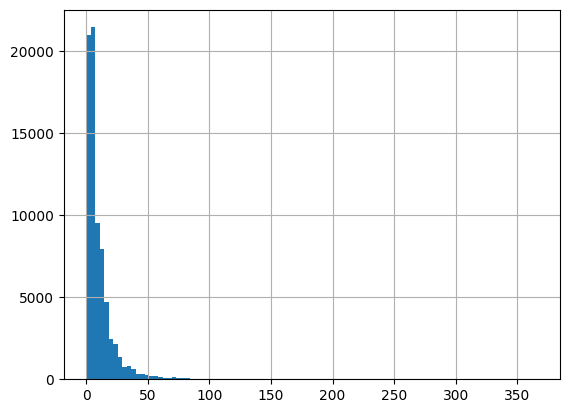

In [17]:
comments['lem_word_count'].hist(bins=100)

In [18]:
comments['lem_sym_count'].describe()

count    74949.000000
mean        78.322526
std        102.385678
min          0.000000
25%         23.000000
50%         48.000000
75%         95.000000
max       3244.000000
Name: lem_sym_count, dtype: float64

<AxesSubplot: >

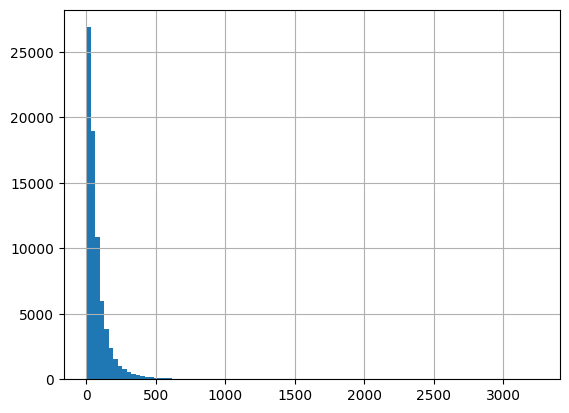

In [19]:
comments['lem_sym_count'].hist(bins=100)

Большинство наблюдений не превышает 50 слов в комментариях
Большинство наблюдений не превышает 200 символов в комментариях

# Оценка токенов

In [20]:
from nltk import word_tokenize

all_text = [word_tokenize(line) for line in lemmatized]

In [21]:
from nltk import FreqDist


n_types = []
n_tokens = []
fd = FreqDist()
for line in all_text:
    fd.update(line)
    n_types.append(len(fd))
    n_tokens.append(sum(list(fd.values())))
for i in fd.most_common(10):
    print(i)

('спасибо', 12689)
('очень', 12263)
('это', 10953)
('косметика', 9995)
('видео', 8963)
('кожа', 8075)
('корейский', 7264)
('крем', 6370)
('ваш', 5459)
('весь', 5059)


## Закон Ципфа
В любом достаточно большом тексте ранг типа обратно пропорционален его частоте: f=a/r

f – частота типа, r – ранг типа, a – параметр, для славянских языков – около 0.07

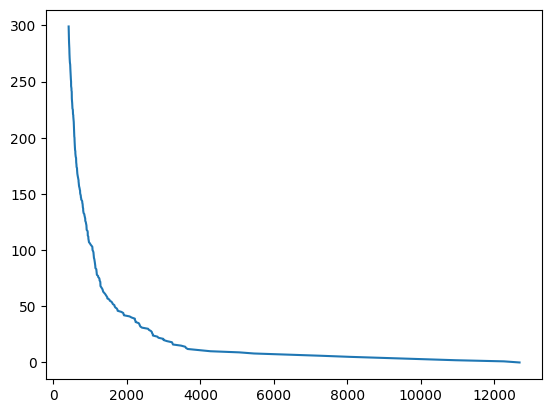

In [22]:
import matplotlib.pyplot as plt

freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

## Закон Хипса
С увеличением длины текста (количества токенов), количество типов увеличивается в соответствии с законом: |V|=K∗N^b

N – число токенов, |V| – количество типов в словаре, K,b – параметры, обычно K∈[10,100],b∈[0.4,0.6]

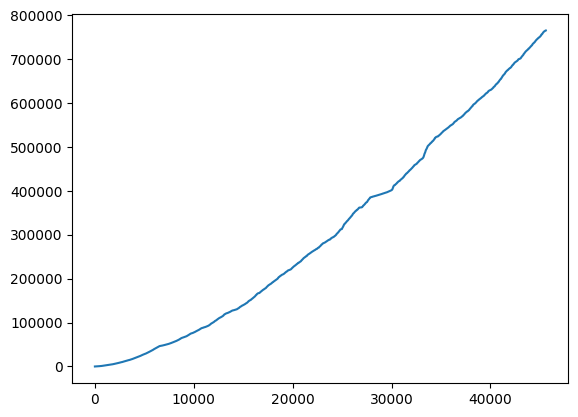

In [23]:
fig, ax = plt.subplots()
ax.plot(n_types, n_tokens)
plt.show()

# Фильтр для анализа

Для улучшения параметров моделирования рекомендуется использоваться относительно большие тексты комментариев

Одновременно с этим мы уменьшим количество текстов для анализа


In [24]:
comments['lem_word_count'].describe()

count    74949.000000
mean        10.212131
std         12.987554
min          0.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        366.000000
Name: lem_word_count, dtype: float64

In [25]:
selected_cmts = comments[comments['lem_word_count'] >= 6]



,kind,etag,id,snippet.videoId,snippet.textDisplay,snippet.textOriginal,snippet.authorDisplayName,snippet.authorProfileImageUrl,snippet.authorChannelUrl,snippet.authorChannelId.value,...,snippet.updatedAt,snippet.canReply,snippet.totalReplyCount,snippet.isPublic,snippet.moderationStatus,snippet.parentId,cleaned_text,lemmatized_text,lem_word_count,lem_sym_count
0,youtube#commentThread,0k0BN3l02ihEAO1Tpx9iNp6S9ZU,UgyKlKuQTfZlkw5sqeN4AaABAg,AAjsSrjZXsw,"Люди тупые, они не понимают, что оригинал стои...","Люди тупые, они не понимают, что оригинал стои...",Елена Марьина,https://yt3.ggpht.com/ytc/AGIKgqM3X8z1SO9ODCNk...,http://www.youtube.com/channel/UCK3lFIDZOZ4rnc...,UCK3lFIDZOZ4rncDMhNB_CbA,...,2023-04-21T12:49:12Z,1.0,0.0,1.0,NaN,-1,"Люди тупые, они не понимают, что оригинал стои...",человек тупой понимать оригинал стоять офигенн...,9,65
3,youtube#commentThread,PtN9_fEasELRW9S1Y7AAtR6OYy8,UgxQi90tx9SVF0IauDN4AaABAg,AAjsSrjZXsw,Не понимаю маниакального желания покупать коре...,Не понимаю маниакального желания покупать коре...,Glapfira Nikolaevna,https://yt3.ggpht.com/ytc/AGIKgqM0Fnoc1nMvlwuO...,http://www.youtube.com/channel/UCnAYp5V6juJLe5...,UCnAYp5V6juJLe5Kt61YcK1g,...,2023-04-15T08:11:42Z,1.0,0.0,1.0,NaN,-1,Не понимаю маниакального желания покупать коре...,понимать маниакальный желание покупать корейск...,25,245
4,youtube#commentThread,XzPn7hMxSpX2yOI5d2m3PsKJZXE,UgwYIO4Dwr8lwOl5_jl4AaABAg,AAjsSrjZXsw,Пару лет назад на Озон купила духи D&G The One...,Пару лет назад на Озон купила духи D&G The One...,Гурия Мирзаева,https://yt3.ggpht.com/6ayZjUJzCfjZIzeL3xWnkfIt...,http://www.youtube.com/channel/UCPdpiRSh32Z_aF...,UCPdpiRSh32Z_aFnkpFfR9jQ,...,2023-04-14T08:32:11Z,1.0,0.0,1.0,NaN,-1,Пару лет назад на Озон купила духи D&G The One...,пара год назад озон купить дух d g the one жен...,44,309
5,youtube#commentThread,ejjL-URwm0My3iMZ4dXw6JZipt4,UgxvyL4Z2XXYCvnraL54AaABAg,AAjsSrjZXsw,"Я дико извиняюсь, но слово контрофакт, если я ...","Я дико извиняюсь, но слово контрофакт, если я ...",thefallensun_,https://yt3.ggpht.com/xfB8w-1dm4mrr5R-0pzwzAje...,http://www.youtube.com/channel/UCaLhaN-DOPSyWu...,UCaLhaN-DOPSyWumr-0IrJYA,...,2023-04-14T03:33:15Z,1.0,0.0,1.0,NaN,-1,"Я дико извиняюсь, но слово контрофакт, если я ...",дико извиняться слово контрофакт ошибаться выл...,9,79
6,youtube#commentThread,DpkPO14H9A20riVhLcdjFgZEA20,Ugwwha8cCeWK74_460h4AaABAg,AAjsSrjZXsw,Вайлдбериз вообще никого и ничего не уважает и...,Вайлдбериз вообще никого и ничего не уважает и...,Наталья Пирогова,https://yt3.ggpht.com/ytc/AGIKgqPpYjVGUA-96Elq...,http://www.youtube.com/channel/UCLfU6hoVJVcc_1...,UCLfU6hoVJVcc_1vq_qU6CEw,...,2023-04-13T19:51:06Z,1.0,0.0,1.0,NaN,-1,Вайлдбериз вообще никого и ничего не уважает и...,вайлдбериз вообще никто ничто уважать далеко э...,9,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74955,youtube#comment,4JaIuAQDjUbqIJHEYBJjYuJb2nQ,Ugwz6GshlUZMMumE9n54AaABAg.9kO7ERtCXa_9kODjmNACUy,boB2LEXG_zA,Марципану можно придать любую форму-...батончи...,Марципану можно придать любую форму-...батончи...,Nadeschda Schmunk,https://yt3.ggpht.com/ytc/AGIKgqO0H2st_sGuf3x2...,http://www.youtube.com/channel/UCg_7OSCvXQr2UI...,UCg_7OSCvXQr2UIs6VdastrA,...,2023-01-02T15:15:14Z,NaN,NaN,NaN,NaN,Ugwz6GshlUZMMumE9n54AaABAg,Марципану можно придать любую форму-...батончи...,марципан придавать любой форма батончик шарик ...,19,143
74959,youtube#comment,76ZikfK-4FYaTjhUiQ7t2XpvUQM,Ugwz6GshlUZMMumE9n54AaABAg.9kO7ERtCXa_9kOAgUwU2Jj,boB2LEXG_zA,@Elena CamilleriУ вас итальянская фамилия...в ...,@Elena CamilleriУ вас итальянская фамилия...в ...,Nadeschda Schmunk,https://yt3.ggpht.com/ytc/AGIKgqO0H2st_sGuf3x2...,http://www.youtube.com/channel/UCg_7OSCvXQr2UI...,UCg_7OSCvXQr2UIs6VdastrA,...,2023-01-02T14:48:34Z,NaN,NaN,NaN,NaN,Ugwz6GshlUZMMumE9n54AaABAg,CamilleriУ вас итальянская фамилия...в Италии...,camilleriу итальянский фамилия италия марципан...,14,111
74960,youtube#comment,EpQVpJK1kawzMPVjx2yo7dLgZPU,Ugwz6GshlUZMMumE9n54

In [27]:
vars = ['id',
        'snippet.videoId',
        'snippet.textDisplay',
        'snippet.textOriginal',
        'snippet.authorDisplayName',
        'snippet.parentId',
        'cleaned_text',
        'lemmatized_text'
        ]

selected_cmts.to_csv(DATA_PATH / 'comment' / 'comments_all.csv', sep='\t', index=False)
selected_cmts[vars].to_csv(DATA_PATH / 'comment' / 'comments_text.csv', sep='\t', index=False)